# Classic Dogs vs. Cats problem in Deep Learning with a twist:
This is a fun deep learning exercise devised by [Abhishek Thakur](https://www.linkedin.com/posts/abhi1thakur_deeplearning-datascience-machinelearning-activity-6797082719605010432-Ne3H) . The problem statements are given below:


1. 🔵 Gather all cat images from here: https://lnkd.in/dm7jCaC
2. 🔵 Gather all dog images from here: https://lnkd.in/dDqFSUC
3. 🔵 Divide by dog breeds into two sets: training and test. Note breeds in the test set cannot appear in the training set.
4. 🔵 Use training dog breeds with all cat images to train a model
5. 🔵 Evaluate this model on holdout dog breeds
6. 🔵 Is your model able to detect all dogs in your dogs test set?
7. 🔵 What is the accuracy? How many dogs are not classified as dogs?
8. 🔵 Note: you can't use a pre-trained model. Because they already know everything.

**What I have done so far**
1.   Downloaded and organized the data to create the dataset specified in the challange.
2.   As the test images in both **Cats vs Dogs dataset** and **Dog breed classifier dataset** aren't labeled, we won't be able to use those for testing to be sure.
3. I have taken **12500** labeled training cat images and **10222 **training dog breed images (as these are labeled) and separated them into train and test set.
4. The dog images taken for training and testing are separated by the breeds. There are total of **120** unique breeds present in the dataset. I have taken **105** breeds for training and **15** for testing resulting in **8995** dog images for training and **1227** dog images for testing statifying the different breed constraint.
5. After that I have taken equal **8995** cat images for training and rest **3505** for testing.
6. I am using existing architectures (not pretrained weights) in both keras and pytorch.

**Future improvements**
1. Try out and intigrate diffrent MLOps tools like MLflow, WanDB, Neptune etc.







## Authenticate google account


In [1]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Download the dataset from google bucket

In [2]:
!gsutil -m cp gs://tibot-ml-labeling/datasets/cats_vs_dogs_dataset.zip  ./

Copying gs://tibot-ml-labeling/datasets/cats_vs_dogs_dataset.zip...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1/1 files][593.6 MiB/593.6 MiB] 100% Done  18.8 MiB/s ETA 00:00:00           
Operation completed over 1 objects/593.6 MiB.                                    


In [3]:
!unzip -q /content/cats_vs_dogs_dataset.zip

replace dataset/test/cats/cats762.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
# Import the required libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
from google.cloud import storage
import numpy as np
from tensorflow.keras.models import Sequential, Model
import os

In [5]:
# Define dataset paths
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

# Define image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32
num_classes = 2  # Assuming you have 2 classes (cats and dogs)

# Create data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse',  # For sparse categorical crossentropy
    shuffle=True  # Shuffle the training data
)

# Create a data generator without augmentation for testing
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse',  # For sparse categorical crossentropy
    shuffle=False  # Do not shuffle the testing data
)

Found 17990 images belonging to 2 classes.
Found 4732 images belonging to 2 classes.


In [6]:
# Define the EfficientNetV2B2 model with ImageNet weights
base_model = EfficientNetV2B2(
    include_top=False,
    weights=None,
    input_shape=(img_width, img_height, 3),
    pooling=None,
)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # You can adjust the learning rate
    loss='sparse_categorical_crossentropy',  # Sparse categorical crossentropy for multi-class classification
    metrics=['accuracy']
)

In [7]:
# Define custom callback to upload the model to Google Cloud Storage
class UploadModelCallback(Callback):
    def __init__(self, bucket_name, remote_dir, num_epochs=1):
        super().__init__()
        self.num_epochs = num_epochs
        self.bucket_name = bucket_name
        self.remote_dir = remote_dir
        self.local_dir = "/content/models"

        # Create a client to interact with Google Cloud Storage
        self.storage_client = storage.Client()

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) >= 1:  # Print the message after each epoch
            # Save the model locally
            filepath = os.path.join(self.local_dir, f"Cats_vs_Dogs_EffB0-{epoch + 1:02d}.h5")
            self.model.save(filepath, include_optimizer=True)

            # Upload the model to Google Cloud Storage
            remote_filepath = os.path.join(self.remote_dir, os.path.basename(filepath))
            bucket = self.storage_client.bucket(self.bucket_name)
            blob = bucket.blob(remote_filepath)
            blob.upload_from_filename(filepath)

            print(f"Model saved in {filepath} and uploaded to {remote_filepath}")

# Usage example:
bucket_name = "tibot-ml-labeling"
remote_dir = "models/cats_vs_dogs_task/sarim/EfficientNetV2B2_Random_Weight/model"
num_epochs = 10
upload_callback = UploadModelCallback(bucket_name, remote_dir, num_epochs)

In [8]:
# Define the number of epochs and other hyperparameters
epochs = 10  # Adjust as needed

# Train the model with the custom callback
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    verbose=1,
    callbacks=[upload_callback]  # Add the custom callback here
)

Epoch 1/10
563/563 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.5628

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved in /content/models/Cats_vs_Dogs_EffB0-01.h5 and uploaded to models/cats_vs_dogs_task/sarim/EfficientNetV2B2_Random_Weight/model/Cats_vs_Dogs_EffB0-01.h5
563/563 [==============================] - 279s 396ms/step - loss: 0.6883 - accuracy: 0.5628 - val_loss: 2.1139 - val_accuracy: 0.2597
Epoch 2/10
563/563 [==============================] - 213s 378ms/step - loss: 0.5985 - accuracy: 0.6747 - val_loss: 12.3946 - val_accuracy: 0.2593
Epoch 3/10
563/563 [==============================] - 214s 379ms/step - loss: 0.5233 - accuracy: 0.7432 - val_loss: 1.1409 - val_accuracy: 0.7407
Epoch 4/10
563/563 [==============================] - 212s 377ms/step - loss: 0.4982 - accuracy: 0.7577 - val_loss: 0.6858 - val_accuracy: 0.7407
Epoch 5/10
563/563 [==============================] - 213s 377ms/step - loss: 0.4789 - accuracy: 0.7694 - val_loss: 0.4764 - val_accuracy: 0.7889
Epoch 6/10
563/563 [==============================] - 213s 378ms/step - loss: 0.4713 - accuracy: 0.7775 - val_loss:

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

148/148 [==============================] - 11s 62ms/step


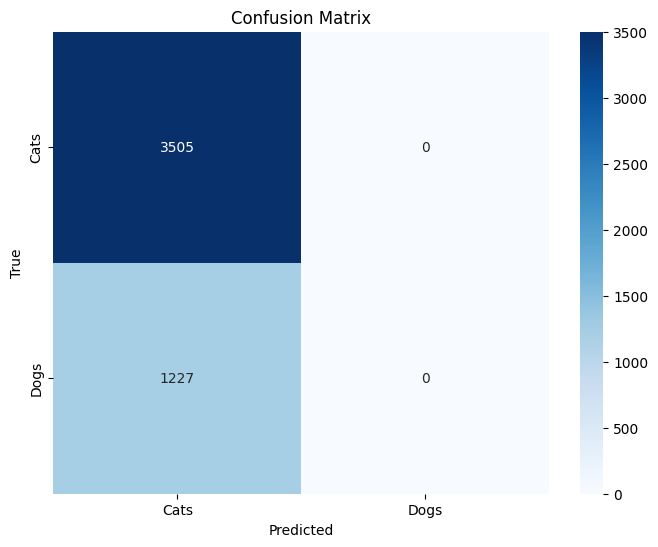

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        Cats       0.74      1.00      0.85      3505
        Dogs       0.00      0.00      0.00      1227

    accuracy                           0.74      4732
   macro avg       0.37      0.50      0.43      4732
weighted avg       0.55      0.74      0.63      4732



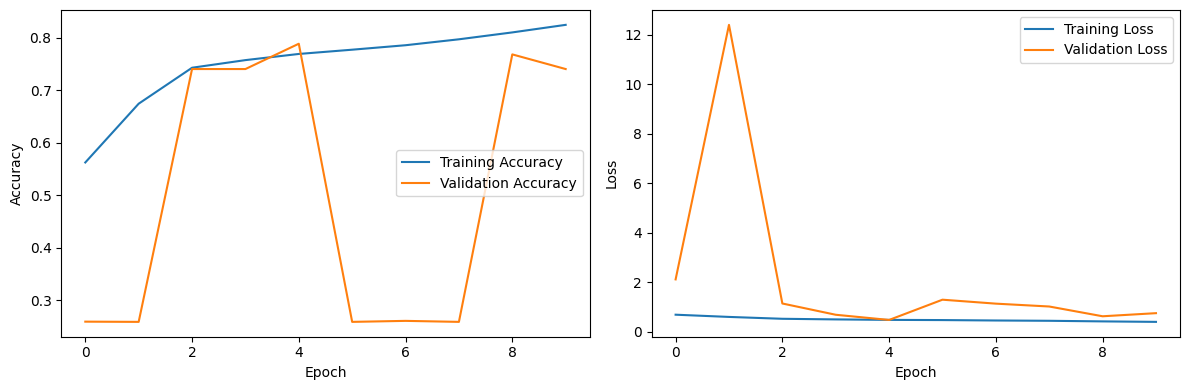

In [10]:
# Generate predictions for the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Get true class labels
y_true = test_generator.classes

# Calculate confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix (you can use a library like Matplotlib)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Cats", "Dogs"],
            yticklabels=["Cats", "Dogs"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate and print classification report
class_names = ['Cats', 'Dogs']
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


# Define dataset paths
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

# Define image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32
num_classes = 2  # Assuming you have 2 classes (cats and dogs)

# Create data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse',  # For sparse categorical crossentropy
    shuffle=True  # Shuffle the training data
)

# Create a data generator without augmentation for testing
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse',  # For sparse categorical crossentropy
    shuffle=False  # Do not shuffle the testing data
)

# Define the EfficientNetB2 model with random weights
base_model = EfficientNetB2(
    include_top=False,
    weights=None,  # No pre-trained weights for random initialization
    input_shape=(img_width, img_height, 3),
    pooling=None,
)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # You can adjust the learning rate
    loss='sparse_categorical_crossentropy',  # Sparse categorical crossentropy for multi-class classification
    metrics=['accuracy']
)

Found 17990 images belonging to 2 classes.
Found 4732 images belonging to 2 classes.


In [18]:
# Define custom callback to upload the model to Google Cloud Storage
class UploadModelCallback(Callback):
    def __init__(self, bucket_name, remote_dir, num_epochs=1):  # Change num_epochs to 1
        super().__init__()
        self.num_epochs = num_epochs
        self.bucket_name = bucket_name
        self.remote_dir = remote_dir
        self.local_dir = "/content/models"

        # Create a client to interact with Google Cloud Storage
        self.storage_client = storage.Client()

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) >= 1:  # Print the message after each epoch
            # Save the model locally
            filepath = os.path.join(self.local_dir, f"Cats_vs_Dogs_EffB0-{epoch + 1:02d}.h5")
            self.model.save(filepath, include_optimizer=True)

            # Upload the model to Google Cloud Storage
            remote_filepath = os.path.join(self.remote_dir, os.path.basename(filepath))
            bucket = self.storage_client.bucket(self.bucket_name)
            blob = bucket.blob(remote_filepath)
            blob.upload_from_filename(filepath)

            print(f"Model saved in {filepath} and uploaded to {remote_filepath}")

# Usage example:
bucket_name = "tibot-ml-labeling"
remote_dir = "models/cats_vs_dogs_task/sarim/EfficientNetB2_Random_Weight/model"
num_epochs = 10
upload_callback = UploadModelCallback(bucket_name, remote_dir, num_epochs)

In [19]:
# Define the number of epochs and other hyperparameters
epochs = 10  # Adjust as needed

# Train the model with the custom callback
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    verbose=1,
    callbacks=[upload_callback]  # Add the custom callback here
)

Epoch 1/10
563/563 [==============================] - ETA: 0s - loss: 0.5955 - accuracy: 0.7000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved in /content/models/Cats_vs_Dogs_EffB0-01.h5 and uploaded to models/cats_vs_dogs_task/sarim/EfficientNetB2_Random_Weight/model/Cats_vs_Dogs_EffB0-01.h5
563/563 [==============================] - 297s 433ms/step - loss: 0.5955 - accuracy: 0.7000 - val_loss: 0.5470 - val_accuracy: 0.7445
Epoch 2/10
563/563 [==============================] - 235s 416ms/step - loss: 0.4987 - accuracy: 0.7628 - val_loss: 0.4763 - val_accuracy: 0.7819
Epoch 3/10
563/563 [==============================] - 235s 417ms/step - loss: 0.4417 - accuracy: 0.7994 - val_loss: 0.6546 - val_accuracy: 0.8187
Epoch 4/10
563/563 [==============================] - 236s 418ms/step - loss: 0.3935 - accuracy: 0.8235 - val_loss: 0.8190 - val_accuracy: 0.6363
Epoch 5/10
563/563 [==============================] - 235s 417ms/step - loss: 0.3552 - accuracy: 0.8452 - val_loss: 1.0920 - val_accuracy: 0.5782
Epoch 6/10
563/563 [==============================] - 235s 416ms/step - loss: 0.3260 - accuracy: 0.8614 - val_loss: 0.

148/148 [==============================] - 14s 82ms/step
Classification Report:
              precision    recall  f1-score   support

        cats       0.99      0.75      0.85      3505
        dogs       0.58      0.98      0.73      1227

    accuracy                           0.81      4732
   macro avg       0.78      0.86      0.79      4732
weighted avg       0.88      0.81      0.82      4732



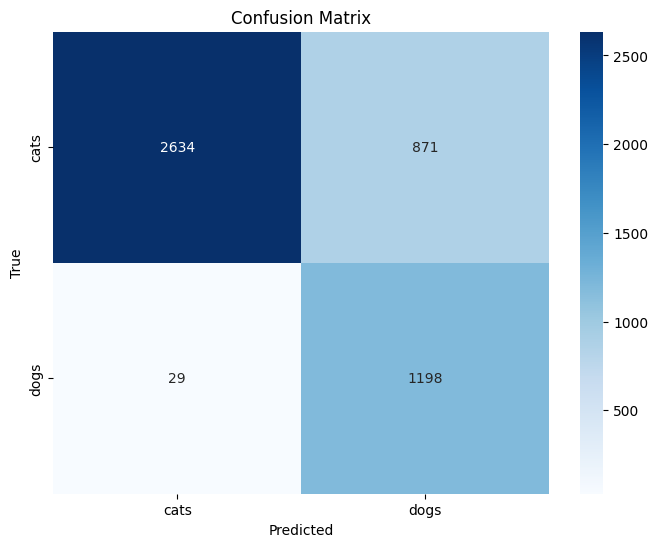

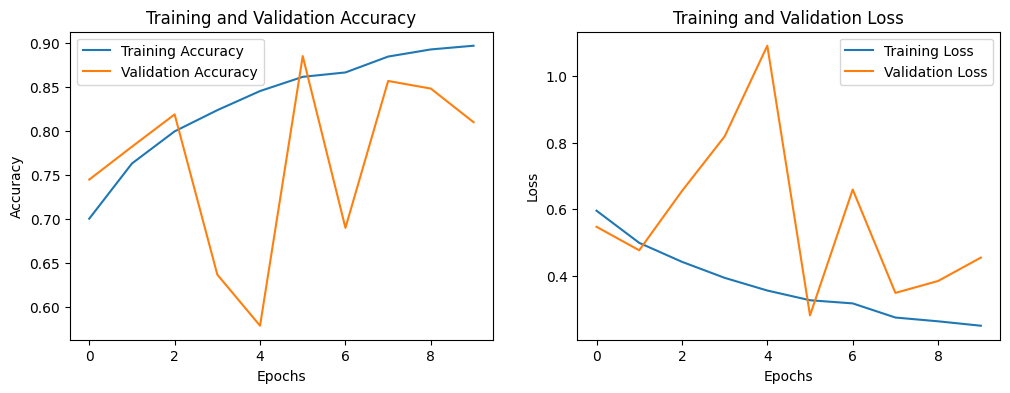

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Reset the test generator to get predictions
test_generator.reset()

# Make predictions on the test data
predictions = model.predict(test_generator)

# Get true labels and predicted labels
true_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Create the classification report
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_labels)

# Create the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:")
print(classification_rep)

# Print the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot the accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()